A very common problem encountered by people learning Fourier optics or diffraction theory is the determination of the far field diffraction pattern from a rectangular aperture. This problem has a clean, analytical solution. Those who are familiar with MATLAB or a similar language may try to write computer code that calculates this diffraction pattern based on [fast Fourier transform (FFT)](http://mathworld.wolfram.com/FastFourierTransform.html) implementations. Unfortunately, the output of the is code not, strictly speaking, the same as predicted by the analytical solution for a few reasons:
1. The analytical solution is a function of continuous variables in space, whereas the simulated solution requires taking discrete samples of the relevant fields.
2. The analytical solution is not band-limited. Therefore, aliasing will distort the computed solution.

[In my last post](http://kmdouglass.github.io/posts/simulating-microscope-pupil-functions.html) I showed how to do basic pupil function simulations but did not go into many details about the FFT and possible errors associated with it. In this post I will dig a bit deeper into the topic of the FFT and its use in computational wave optics.

The purpose of this post is to investigate differences between the analytical theory and the simulated solution of the diffraction pattern from a rectangular aperture by investigating the simpler problem of diffraction from a 1D slit.

In [1]:
%pylab
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'plasma' 

from scipy.fftpack import fft
from scipy.fftpack import fftshift

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


# Scalar diffraction theory for a 1D slit
[Goodman](https://books.google.ch/books/about/Introduction_to_Fourier_Optics.html?id=ow5xs_Rtt9AC&redir_esc=y) and [many others](https://en.wikipedia.org/wiki/Fraunhofer_diffraction_%28mathematics%29#Examples_of_Fraunhofer_diffraction_with_a_normally_incident_monochromatic_plane_wave) have shown that the far-field (also known as Fraunhofer) solution to the diffracted electric field from a rectangular aperture is proportional to the Fourier transform of the field distribution in the aperture. This fact follows directly from applying the Fraunhofer approximation to the diffraction integral developed by Huygens and Fresnel ([Goodman](https://books.google.ch/books/about/Introduction_to_Fourier_Optics.html?id=ow5xs_Rtt9AC&redir_esc=y)).

For both convenience and numerical efficiency, I will focus on the one-dimensional analog to this problem: diffraction from an infinitely-long slit with width \\( a \\). If there is an incident monochromatic plane wave with amplitude \\(E_0\\) traveling in the z-direction perpendicular to a slit in the \\(z=0\\) plane, then the Fraunhofer diffraction pattern for the field is expressed by the equation

$$U \left(x', z \right) = \frac{e^{jkz} e^{ jk\frac{x'^2}{2z} }}{\sqrt{j \lambda z}} \int_{-\infty}^{\infty} u \left( x, z = 0 \right) \exp \left( -j \frac{2 \pi}{\lambda z} xx'\right) dx $$

with \\(u \left( x, z = 0 \right) = E_0 \\) denoting the incident field, \\( k = \frac{2 \pi}{\lambda} \\) representing the freespace wavenumber, \\( x = 0 \\) and \\( x' = 0 \\) the center planes of the slit and diffraction patterns, respectively, and \\( j \\) the imaginary number. The factor \\( \sqrt{j \lambda z} \\) comes from [separating the solution to the 2D Huygens-Fresnel integral into two, 1D solutions](https://www.kth.se/polopoly_fs/1.569752!/Gaussian%20beams.pdf). The irradiance in the z-planes after the slit is [proportional to the absolute square of the field](https://en.wikipedia.org/wiki/Poynting_vector),

$$I \left( x', z \right) \propto \left| U \left( x', z \right) \right|^2$$

Taking the absolute square eliminates the complex exponentials preceding the integral so that the irradiance profile becomes

$$I \left( x', z \right) \propto \frac{1}{\lambda z} \left| \int_{-\infty}^{\infty} u \left( x \right) \exp \left( -j \frac{2 \pi}{\lambda z} xx'\right) dx \right|^2 = \frac{1}{\lambda z} \left| \mathcal{F} \left[ u \left( x, z \right) \right] \left( \frac{x'}{\lambda z}\right) \right|^2 $$

This expression means that the irradiance describing the Fraunhofer diffraction pattern from slit is proportional to the absolute square of the Fourier transform of the field at the aperture evaluted at spatial frequencies \\( f_{x} = x' / \lambda z\\). To arrive at the analytical solution, we perform the integration over a region where the slit is not opaque, \\( \left[ -a/2, a/2 \right] \\). Inside this region, the field is simply \\( u \left( x \right) = E_0 \\) because we have a monochromatic plane wave with this amplitude.

$$ \mathcal{F}\left[ u \left( x, z \right) \right] = \int_{-a/2}^{a/2} E_0 \exp \left( -j \frac{2 \pi}{\lambda z} xx'\right) dx $$

The analytical solution to this integral is

$$ \mathcal{F}\left[ u \left( x, z \right) \right] = a E_0 \text{sinc} \left( \frac{ax'}{\lambda z} \right) $$

where \\( \text{sinc} \left( x \right) = \frac{\sin{\pi x}}{\pi x}\\). The far-field irradiance is therefore the absolute square of this quantity divided by the product of the wavelength and the propagation distance.

Let's plot the analytically-determined irradiance profile of the diffraction pattern:

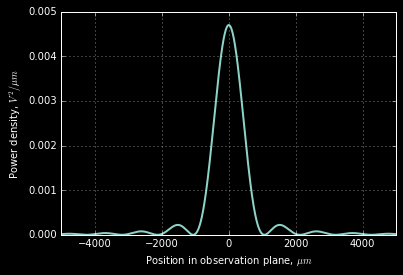

In [2]:
# Create a sinc function to operate on numpy arrays
def sinc(x):
    if (x != 0):
        # Prevent divide-by-zero
        return np.sin(np.pi * x) / (np. pi * x)
    else:
        return 1
sinc = np.vectorize(sinc)

amplitude    = 1     # Volt / sqrt(micron)
slitWidth    = 5     # microns
wavelength   = 0.532 # microns
propDistance = 10000 # microns (= 10 mm)

x = np.arange(-10000, 10000, 1)
F = sinc(slitWidth * x / wavelength / propDistance)
I = amplitude / (wavelength * propDistance) * (slitWidth * F)**2

plt.plot(x, I, linewidth = 2)
plt.xlim((-5000, 5000))
plt.xlabel(r'Position in observation plane, $\mu m$')
plt.ylabel('Power density, $V^2 / \mu m$')
plt.grid(True)
plt.show()

We can also verify a few key properties of the Fourier transform and ensure that our units are correct. The most important property is the conservation of energy, which in signal processing is often known as [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem). In our case, conservation of energy means that the integral of the field over the slit must equal the integral of the field in any arbitrary z-plane.

$$\int_{-\infty}^{\infty} \left| u \left( x, z = 0 \right) \right|^2 dx = \int_{-\infty}^{\infty} \left| U \left( x', z \right) \right|^2 dx'$$

where the spatial frequency is \\( f_{x} = \frac{x'}{\lambda z} \\). Because the incident field is a plane wave, the integral over the slit is just the square of the plane wave amplitude multiplied by the slit width:

$$\int_{-a/2}^{a/2} E_0^2 dx = aE_0^2$$

We need the square integral to be proportional to units of power, which will be true if the field has units of \\( \frac{\text{Volts}}{\sqrt{\mu m}} \\) and not the more familiar \\( \frac{\text{Volts}}{\mu m} \\). This peculiarity stems from the fact that we're looking at a somewhat synthetic 1D case. With this in mind, the square integral has units of \\( \text{Volts}^2 \\) and is proportional to the power delivered by the plane wave.

The absolute square of the diffracted field is

$$ \left| U \left( x', z \right) \right|^2 = \frac{a^2 E_0^2}{\lambda z} \text{sinc}^2 \left( \frac{a x'}{\lambda z} \right)$$

The integral of \\( \text{sinc}^2 \left( x \right) \\) with my definition of \\( \text{sinc} \left( x \right) \\) [over the real number line](http://math.stackexchange.com/questions/903117/integral-of-sinc-function-squared-over-the-real-line) is just 1, so

$$ \int_{-\infty}^{\infty} \left| U \left( x', z \right) \right|^2 dx' = \frac{a^2 E_0^2}{\lambda z} \times \frac{\lambda z}{a} = aE_0^2$$

All of this is essentially a verification that our units and prefactors have most likely been handled correctly. Most Fourier optics texts drop a lot of prefactors in their derivations, so it's always good to check that they've done everything correctly :)

In [3]:
from scipy.integrate import simps
# Compute input power
powerIn  = slitWidth * amplitude**2

# Compute output power by numerical integration of the sinc
prefactor    = slitWidth **2 * amplitude**2 / wavelength / propDistance
sincIntegral = simps(F, x)
powerOut     = prefactor * sincIntegral

print('The input power is {0:.4f} square Volts. The output power is {1:.4f} square Volts'.format(powerIn, powerOut))

The input power is 5.0000 square Volts. The output power is 5.0373 square Volts


# Simulating slit diffraction with the FFT
Can we simply use the FFT in Python's Scipy or in MATLAB to arrive at the same solution as above, skipping the math in the process? Let's try it.

We'll start by defining a square slit centered at the origin with the same width as above. The incident field is a plane wave with amplitude \\(E_0 = 1 \, V / \sqrt{m} \\).

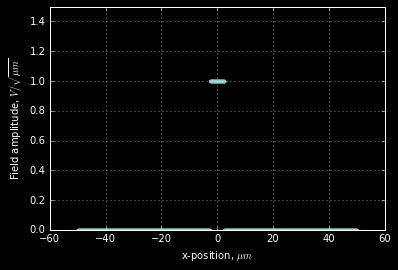

In [4]:
x     = np.linspace(-50, 50, num = 1024)
field = np.zeros(x.size, dtype='complex128') # Ensure the field is complex

field[np.logical_and(x > -slitWidth / 2, x <= slitWidth / 2)] = amplitude + 0j

plt.plot(x, np.abs(field), '.')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.ylim((0, 1.5))
plt.grid(True)
plt.show()

Now, it's important to really understand that this slit is represented in computer memory as a discrete sequence of field samples, *not* a continous curve. If we zoom in on the slit, we can better appreciate this:

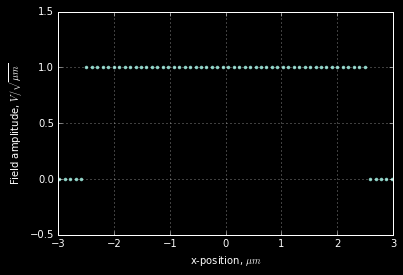

In [5]:
plt.plot(x, np.abs(field), '.')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.xlim((-3, 3))
plt.ylim((-0.5, 1.5))
plt.grid(True)
plt.show()

Let's go ahead now and compute the FFT of this sequence of field samples. We first need to figure out what the units of the FFT are going to be. The sampling frequency \\(f_S\\) for this field is simply 1 divided by the distance between each sample. The FFT outputs an array of numbers from spatial frequency 0 up to \\( \left( \frac{N-1}{N} \right) f_S \\). By default, the length of the output array \\( N \\) is the same as the length of the input. In Python, array indexes start from 0, so the relationship between index \\( i \\) and spatial frequency is

$$ f_{x} = \frac{f_S}{N} i $$

([In MATLAB](http://scholarsarchive.jwu.edu/cgi/viewcontent.cgi?article=1006&context=engineering_fac), array indexes start at 1 so \\(i\\) above should be replaced by \\(i - 1\\) ).

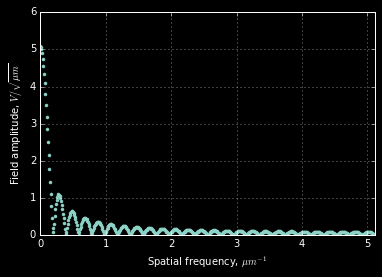

In [6]:
dx = x[1] - x[0] # Spatial sampling period, microns
fS = 1 / dx      # Spatial sampling frequency, units are inverse microns
f  = (fS / x.size) * np.arange(0, x.size, step = 1) # inverse microns

diffractedField = dx * fft(field) # The field must be rescaled by dx to get the correct units

# Plot the field up to the Nyquist frequency, fS / 2
plt.plot(f[f <= fS / 2], np.abs(diffractedField[f <= fS / 2]), '.', linewidth = 2)
plt.xlim((0, fS / 2))
plt.xlabel(r'Spatial frequency, $\mu m^{-1}$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.grid(True)
plt.show()

OK, so far so good. Let's now put the results in a format that is more easily compared to the analytical theory for the diffracted irradiance. First, we'll shift the FFT results so that the peak is in the center. Then, we'll rescale the x-axis by multiplying by \\( \lambda z \\) to get \\(x'\\) and plot the theoretical result on top.

/home/douglass/anaconda3/envs/scipy/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


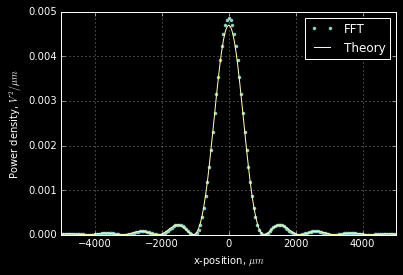

In [7]:
xPrime   = np.hstack((f[-(f.size/2):] - fS, f[0:f.size/2])) * wavelength * propDistance

IrradTheory = amplitude / (wavelength * propDistance) * \
    (slitWidth * sinc(xPrime * slitWidth / wavelength / propDistance))**2
IrradFFT    = fftshift(diffractedField * np.conj(diffractedField)) / wavelength / propDistance

plt.plot(xPrime, np.abs(IrradFFT), '.', label = 'FFT')
plt.plot(xPrime, IrradTheory, label = 'Theory')
plt.xlim((-5000, 5000))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Power density, $V^2 / \mu m$')
plt.grid(True)
plt.legend()
plt.show()

Not too bad! It looks like the simulation and the FFT agree pretty well. But, if we zoom in to some regions of the curve, you can see some discrepancies:

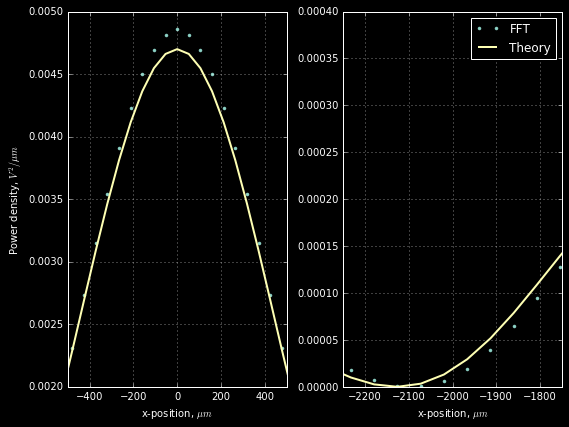

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = ((8,6)))

ax0.plot(xPrime, np.abs(IrradFFT), '.', label = 'FFT')
ax0.plot(xPrime, IrradTheory, label = 'Theory', linewidth = 2)
ax0.set_xlim((-500, 500))
ax0.set_ylim((0.002, 0.005))
ax0.set_xlabel(r'x-position, $\mu m$')
ax0.set_ylabel(r'Power density, $V^2 / \mu m$')
ax0.grid(True)

ax1.plot(xPrime, np.abs(IrradFFT), '.', label = 'FFT')
ax1.plot(xPrime, IrradTheory, label = 'Theory', linewidth = 2)
ax1.set_xlim((-2250, -1750))
ax1.set_ylim((0.000, 0.0004))
ax1.set_xlabel(r'x-position, $\mu m$')
ax1.grid(True)
ax1.legend()

plt.tight_layout()
plt.show()

Considering the discrepancy between the results and the theory, the following question comes to mind:

**Is the discrepancy between the theoretical and FFT results due to numerical rounding errors, how we defined the slit, or something else?**

# How well do the theory and FFT results agree?
Let's start to answer this question by plotting the percent error between the theory and the FFT results.

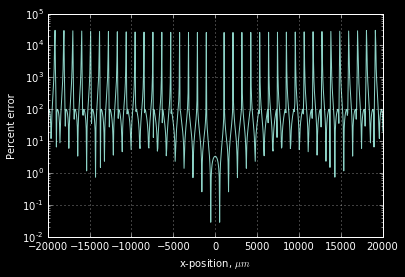

In [9]:
percentError = np.abs((IrradTheory - IrradFFT) / IrradTheory) * 100

plt.semilogy(xPrime, percentError)
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel('Percent error')
plt.xlim((-20000, 20000))
plt.grid(True)
plt.show()

Now *that's* interesting. The percent error varies wildly and spans nearly six orders of magnitude! Furthermore, it appears like the error actually gets slightly worse near the edge of the range, as evidenced by the upwards trend in the positive peaks. Finally, the fact that the percent error appears to have some sort of periodicity suggests that the discrepancies are not due to round-off errors but rather something else.

# Does aliasing cause the disagreement?

Let's first see whether [aliasing](https://en.wikipedia.org/wiki/Aliasing) is causing a problem. The slit is not bandlimited, which means that its Fourier spectrum is infinite in extent. For this reason, we can never sample the slit at high-enough frequencies to and calculate its spectrum without aliasing artifacts. We can however, see if fidelity improves by increasing the sampling rate.

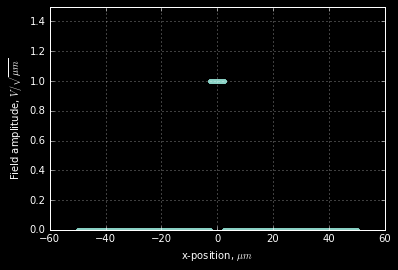

In [10]:
# Increase samples to approximately 1 million (2^20)
xNew        = np.linspace(-50, 50, num = 2**20)
fieldNew    = np.zeros(xNew.size, dtype='complex128') # Ensure the field is complex

fieldNew[np.logical_and(xNew > -slitWidth / 2, xNew <= slitWidth / 2)] = amplitude + 0j

plt.plot(xNew, np.abs(fieldNew), '.')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.ylim((0, 1.5))
plt.grid(True)
plt.show()

/home/douglass/anaconda3/envs/scipy/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


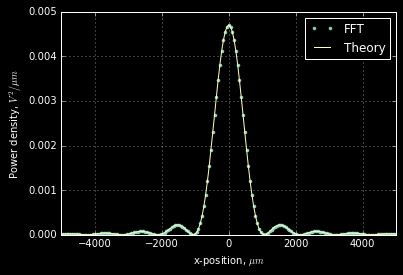

In [11]:
dxNew = xNew[1] - xNew[0] # Spatial sampling period, microns
fS    = 1 / dxNew         # Spatial sampling frequency, units are inverse microns
f     = (fS / xNew.size) * np.arange(0, xNew.size, step = 1) # inverse microns
xPrimeNew   = np.hstack((f[-(f.size/2):] - fS, f[0:f.size/2])) * wavelength * propDistance

diffractedField = dxNew * fft(fieldNew) # The field must be rescaled by dx to get the correct units

IrradTheoryNew = amplitude / (wavelength * propDistance) * \
    (slitWidth * sinc(xPrimeNew * slitWidth / wavelength / propDistance))**2
IrradFFTNew    = fftshift(diffractedField * np.conj(diffractedField)) / wavelength / propDistance

plt.plot(xPrimeNew, np.abs(IrradFFTNew), '.', label = 'FFT')
plt.plot(xPrimeNew, IrradTheoryNew, label = 'Theory')
plt.xlim((-5000, 5000))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Power density, $V^2 / \mu m$')
plt.grid(True)
plt.legend()
plt.show()

Now the agreement looks much better! Here's the new percent error with \\( 2^{20} \\) samples compared to the old one with \\( 2^{10} \\).

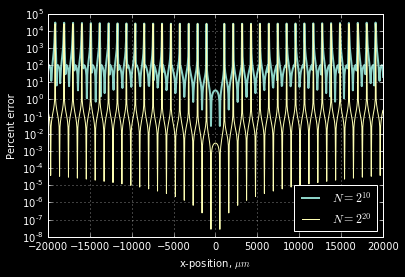

In [12]:
percentErrorNew = np.abs((IrradTheoryNew - IrradFFTNew) / IrradTheoryNew) * 100

plt.semilogy(xPrime,    percentError,       label = r'$N = 2^{10}$', linewidth = 2)
plt.semilogy(xPrimeNew, percentErrorNew, label = r'$N = 2^{20}$')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel('Percent error')
plt.xlim((-20000, 20000))
plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()

Here we see that increasing the sampling rate by nearly three orders of magnitude (1024 samples vs. 1,048,576) improves the relative error at the origin and at the points where the error was already low to begin with. However, it does nothing to improve the error at the peaks in the plot, the first two peaks lying approximately 1000 microns on either side of the origin.

# Just aliasing, or something more?

We can begin to better understand the differences between the computational solution and the analytical solution by first underlining these two facts:
1. The diffracted far-field is a **continous Fourier transform** of the continuous field distribution in the aperture.
2. The FFT produces a **discrete Fourier transform (DFT)** of the sampled field in the aperture.

Since the analytical solution and the FFT solution come from two related but different mathematical operations, should we have expected to get the right answer in the first place? [As others have pointed out](http://ch.mathworks.com/matlabcentral/newsreader/view_thread/294772), the discrete time Fourier transform (DTFT) of a square function is a ratio of two sines, not a sinc. Furthermore, the DFT (and equivalently the FFT result) is simply a sampled version of the DTFT. Therefore, we might expect that sampling the DTFT solution for a square wave will produce the same results as the FFT solution. Let's go ahead and try it.

[According to Wikipedia](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform#Table_of_discrete-time_Fourier_transforms), and changing variables to agree with my notation above, the DTFT solution of the square wave is 

$$F \left( f_{x} \right) = \frac{\sin \left[ \pi f_{x} \left( M + 1 \right) \right] }{\sin \left( \pi f_{x} \right) } e^{ -j \pi f_{x} M }, \, M \in \mathbb{Z} $$

where \\( M \\) is an integer and \\( f\_{x} \\) is the spatial frequency. An important property of the DTFT  is that it is periodic between 0 and 1. If I had used the angular spatial frequency \\( k\_{x} = 2 \pi f\_{x} \\) the periodicity would be between 0 and \\( 2 \pi \\). With this information, we can map our spatial frequency vector onto the appropriate range for the DTFT.

The square function corresponding to this DTFT solution is defined with the left edge of the square starting at the origin:

$$ f \left( x \right) = \text{rect} \left( \frac{n - M/2}{M} \right) , \, M \in \mathbb{Z}, \, n = 0, 1, \ldots, N - 1$$

\\( n \\) is the index of the samples taken from the square and \\( M \\) denotes the center of the square. So, to use this expression for the DTFT of the square, we will first need to shift our original input so that the left edge of the square is at the origin.

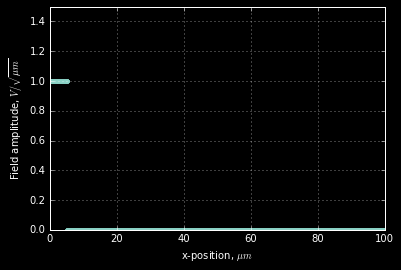

M is 52429.


In [13]:
numSamples = 2**20 # Large numbers of samples needed to make FFT and DTFT agree
x          = np.linspace(0, 100, num = numSamples)
field      = np.zeros(x.size, dtype='complex128') # Ensure the field is complex

field[x <= slitWidth] = amplitude + 0j
M                     = np.sum(np.real(field) / amplitude) # Only works if input field is real and ones.

plt.plot(x, np.abs(field), '.')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.ylim((0, 1.5))
plt.grid(True)
plt.show()

print('M is {0:.0f}.'.format(M))

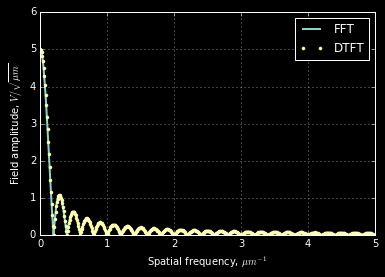

In [14]:
def rectDTFT(f, M):
    # Returns the DTFT of a rect centered at M
    if (f != 0):
        return np.sin(f * np.pi * (M + 1)) \
             / np.sin(f * np.pi)           \
             * np.exp(-1j * f * np.pi * M)
    else:
        return (M + (1 + 0j))
rectDTFT = np.vectorize(rectDTFT)

# Compute the diffracted field with the FFT
dx = x[1] - x[0]
fS = 1 / dx
f  = (fS / x.size) * np.arange(0, x.size, step = 1) # inverse microns
diffractedField = dx * fft(field)

# Sample the DTFT of a rectangular slit
dx_DTFT  = x[1] - x[0]
fS_DTFT  = 1 / dx_DTFT
fDTFT    = np.linspace(0, 1, num = numSamples, endpoint = False) # For plotting the DTFT

plt.plot(f[f <= fS / 2],  np.abs(diffractedField[f <= fS / 2]), linewidth = 2, label = 'FFT')
plt.plot(fDTFT * fS_DTFT, dx_DTFT * np.abs(rectDTFT(fDTFT, M)), '.',           label = 'DTFT')
plt.xlim(0,5)
plt.ylim(0,6)
plt.xlabel(r'Spatial frequency, $\mu m^{-1}$')
plt.ylabel(r'Field amplitude, $V / \sqrt{ \mu m}$')
plt.grid(True)
plt.legend()
plt.show()

I placed the x- and y-axes to display a similar range as the equivalent plot above. We see that the DTFT result, which is the ratio of two sine waves, is also in good agreement with the FFT. So now we have the FFT *and* the DTFT of the field at the aperture modeling the diffraction pattern reasonably well.

How well does the DTFT match the analytical results? Let's look at their percent error and compare it to the one between the analytical theory and the FFT for \\( 2^{20} \\) samples.

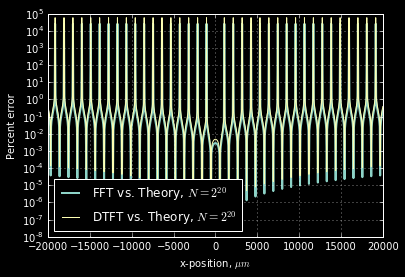

In [15]:
IrradDTFT = dx_DTFT**2 * fftshift(rectDTFT(fDTFT, M) * np.conj(rectDTFT(fDTFT, M))) / wavelength / propDistance
    
percentErrorDTFT = np.abs(IrradTheoryNew - IrradDTFT) / IrradTheoryNew * 100

plt.semilogy(xPrimeNew, percentErrorNew,  label = r'FFT vs. Theory, $N = 2^{20}$', linewidth = 2)
plt.semilogy(xPrimeNew, percentErrorDTFT, label = r'DTFT vs. Theory, $N = 2^{20}$')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel('Percent error')
plt.xlim((-20000, 20000))
plt.grid(True)
plt.legend(loc = 'lower left')
plt.show()

What the above plot shows is that **the error between the analytical theory and both the FFT and DTFT predictions are practically the same**. This means that the FFT is computing the DTFT of the field at the aperture and not the continuous Fourier transform. The DTFT result is therefore inherently including the aliasing artifacts that prevent accurate computation of the diffracted field with the FFT.

Despite the large relative errors, we still get pretty good results with both the FFT and DTFT predictions around the origin so long as the sampling frequency is large, or, equivalently, the grid spacing is small:

/home/douglass/anaconda3/envs/scipy/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


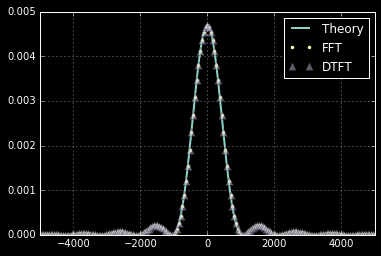

In [16]:
plt.plot(xPrimeNew, IrradTheoryNew,   label = 'Theory', linewidth = 2)
plt.plot(xPrimeNew, IrradFFTNew, '.', label = 'FFT')
plt.plot(xPrimeNew, IrradDTFT,   '^', label = 'DTFT',   markersize = 8, alpha = 0.5)
plt.xlim((-5000, 5000))
plt.grid(True)
plt.legend()
plt.show()

# Summary
This entire exercise effectively showed that it is impossible to compute an exact diffraction pattern from a slit with a straight-forward approach based on the fast Fourier transform. There are two ways of looking at why this is, though they are both effectively based in the same underlying ideas.
1. The spectrum of a slit is not band limited, so aliasing will always distort the FFT calculation.
2. The FFT is computing the discrete time Fourier transform, not the continuous Fourier transform.

Because the slit is not band limited, frequencies in the spectrum that are larger than the field's sampling frequency are effectively folded back into and interfere with the spatial frequencies that are less than the sampling frequency. This creates differences between the analytical theory and its computed estimate.

Similarly, if we pay close attention to the analytical theory, we find that the diffraction pattern results from a *continuous Fourier transform*. The FFT however computes discrete samples of the *discrete time Fourier transform*. These are two similar, but fundamentally different things. Importantly, the DTFT result includes the aliasing artifacts by its very nature; it is a [periodic summation](https://en.wikipedia.org/wiki/Periodic_summation) of the continuous Fourier transform of the field, and this periodic summation results in overlapping tails of the spectra.

If anything, I hope this post clarifies a commmon misconception in Fourier optics, namely that we can compute exact diffraction patterns with the FFT algorithm.